# Adventure Works 2025 Sales Analysis
In this analysis we examine the Adventure Works database to answer business intelligence questions like:
* Product categories and their metrics.
* Trends in sales over time.
* Regional depth metrics.

We will use SQL for the database connection and Python for the visualizations.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import numpy as np

user = "SA"
password = quote_plus("AStIyChGLQQn0K")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

try:
    with engine.connect():
        print("Connection to SQL Server was successful")
except Exception as e:
    print("Could not connect", e)

Connection to SQL Server was successful


C:\Users\pappa\AppData\Local\Temp\ipykernel_28948\209609364.py:22: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql:str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualization 1: Number Of Products Per Category
How many products is there in each category?

Tables used:
* Production.ProductCategory
* Production.ProductSubCategory
* Production.Product

Execution:
* JOIN Tables
* Count DISTINCT products per category
* Create Vertical chart
* Analyze result

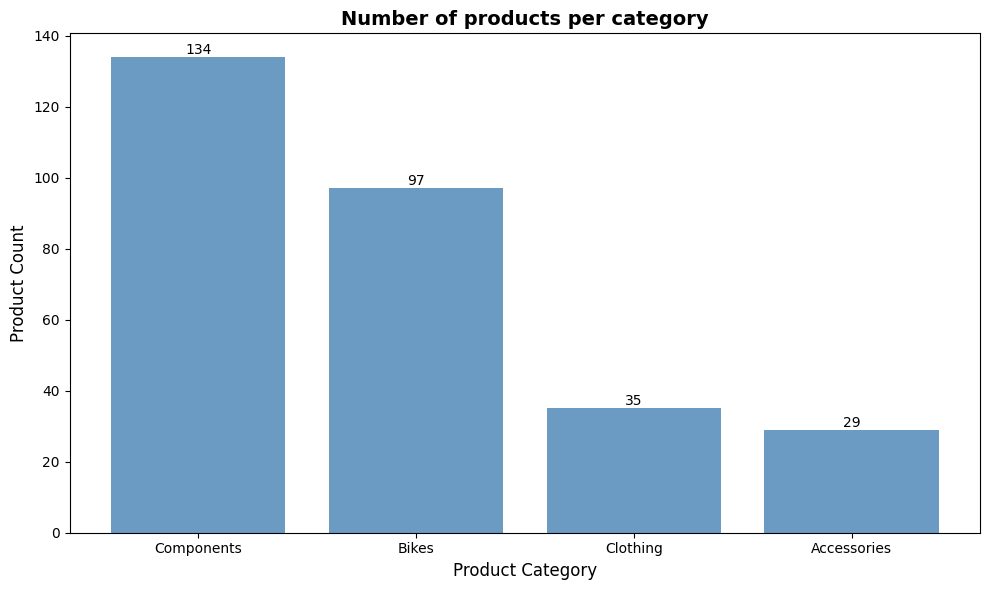

In [3]:
query_vis_1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID  = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis_1 = query_df(query_vis_1)

fig, ax = plt.subplots(figsize = (10,6))
bars = ax.bar(df_vis_1['CategoryName'], df_vis_1['ProductCount'], color = 'steelblue', alpha = 0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f"{int(height)}", ha = 'center', va = 'bottom')

ax.set_xlabel('Product Category', fontsize = 12)
ax.set_ylabel('Product Count', fontsize = 12)
ax.set_title('Number of products per category', fontsize = 14, fontweight = 'bold')
plt.tight_layout()
plt.show()



### Insights - Products Per Catoegory
* Components is the largest category with 134 products.
* Accessories is the smallest category with 29 products.

This indicates that the company is highly focused on components and spare parts. And that accessories could be a area of development.

## Visualization 2: Sales Per Category
Which category generates the highest amount of sales?

Tables used:
* Production.ProductCategory
* Production.ProductSubCategory
* Production.Product
* Sales.SalesOrderDetail

Execution:
* JOIN Tables
* Sum sales per category
* Create Horizontal chart
* Analyze result

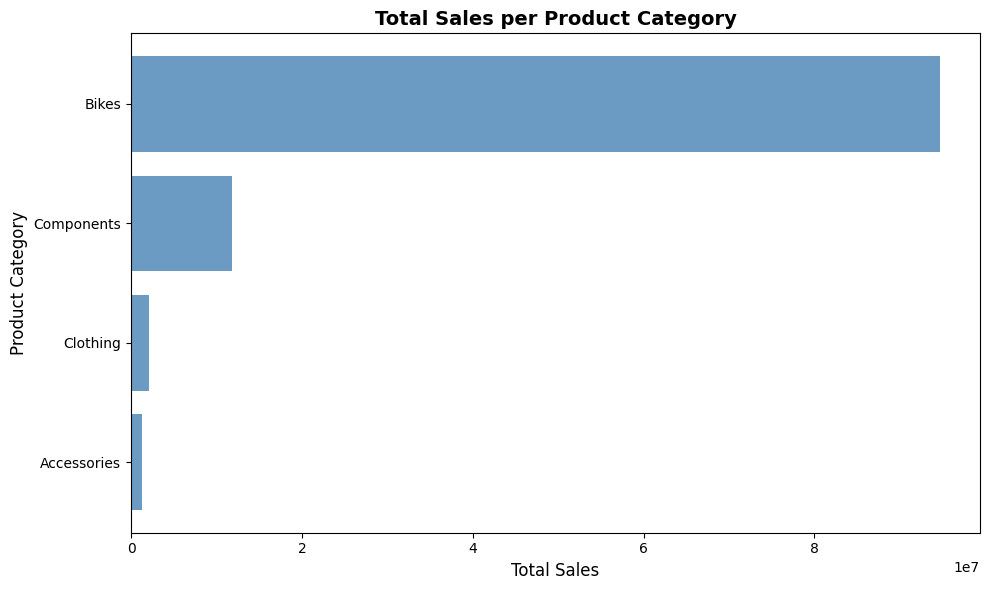

Bikes: 94,651,173
Components: 11,802,593
Clothing: 2,120,543
Accessories: 1,272,073


In [4]:
query_vis_2 = """
SELECT
    pc.Name AS Category,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p ON p.ProductID = sod.ProductID
JOIN Production.ProductSubcategory psc ON psc.ProductSubcategoryID = p.ProductSubcategoryID
JOIN Production.ProductCategory pc ON pc.ProductCategoryID = psc.ProductCategoryID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""

df_vis_2 = query_df(query_vis_2)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_vis_2['Category'], df_vis_2['TotalSales'], color='steelblue', alpha=0.8)

ax.set_xlabel('Total Sales', fontsize=12)
ax.set_ylabel('Product Category', fontsize=12)
ax.set_title('Total Sales per Product Category', fontsize=14, fontweight='bold')

ax.invert_yaxis() 
plt.tight_layout()
plt.show()

print("\n".join(df_vis_2["Category"] + ": " + df_vis_2["TotalSales"].map(lambda x: f"{x:,.0f}")))


### Insights - Sales Per Catoegory
* Bikes has the highest amount of sales with 94.651.173.
* Accessories has the lowest amount of sales with 1.272.073.

Sales are highly concentrated in the Bikes category, which generates significantly more revenue than all other categories.

## Visualization 3: Sales Trend Over Time
What does the sales trend look like over time?

Tables used:
* Sales.SalesOrderHeader

Execution:
* Aggregated sales data by year and month based on order dates.
* Create Horizontal chart
* Analyze result

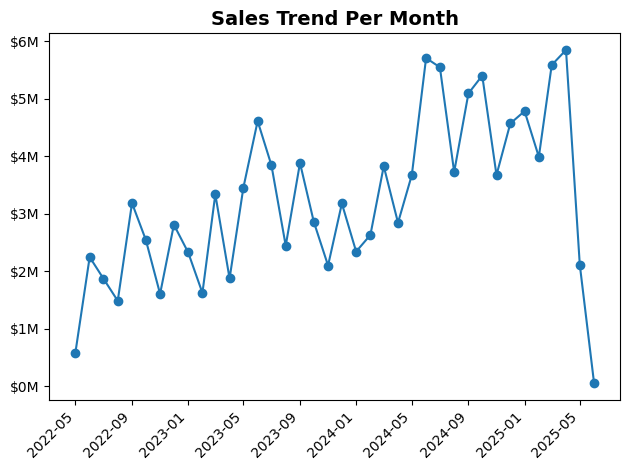

Highest month: 2025-04 (5.8M)
Lowest month: 2025-06 (0.1M)


In [5]:
query_vis_3 = """
SELECT
    YEAR(OrderDate) AS [Year],
    MONTH(OrderDate) AS [MonthNr],
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY [Year], [MonthNr]
"""

df_vis_3 = query_df(query_vis_3)

df_vis_3['Month'] = pd.to_datetime(df_vis_3['Year'].astype(str) + '-' + df_vis_3['MonthNr'].astype(str) + '-01')

plt.plot(df_vis_3['Month'], df_vis_3['TotalSales'], marker='o')
plt.title('Sales Trend Per Month', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'${x/1_000_000:.0f}M'))

plt.tight_layout()
plt.show()

max_row = df_vis_3.loc[df_vis_3['TotalSales'].idxmax()]
min_row = df_vis_3.loc[df_vis_3['TotalSales'].idxmin()]

print(f"Highest month: {max_row['Month'].strftime('%Y-%m')} ({max_row['TotalSales']/1_000_000:.1f}M)")
print(f"Lowest month: {min_row['Month'].strftime('%Y-%m')} ({min_row['TotalSales']/1_000_000:.1f}M)")


### Insights – Sales Trend Over Time
* Highest Monthly: 2025-04 (5847164.693)
* Lowest Mothly: 2025-06 (52478.1872)

Sales show variation over time, with noticeable peaks and troughs across months. With a observable trend upwards, that seem to have ended abruptly at peak month 2025-04.
Certain periods show sharp declines, suggesting potential seasonal effects or incomplete data.

## Visualization 4: Sales And Orders Per Year
What does the total sales and orders per year look like?

Tables used:
* Sales.SalesOrderHeader

Execution:
* Aggregate total sales per year
* Count number of orders per year
* Create grouped bar chart
* Analyze yearly trends

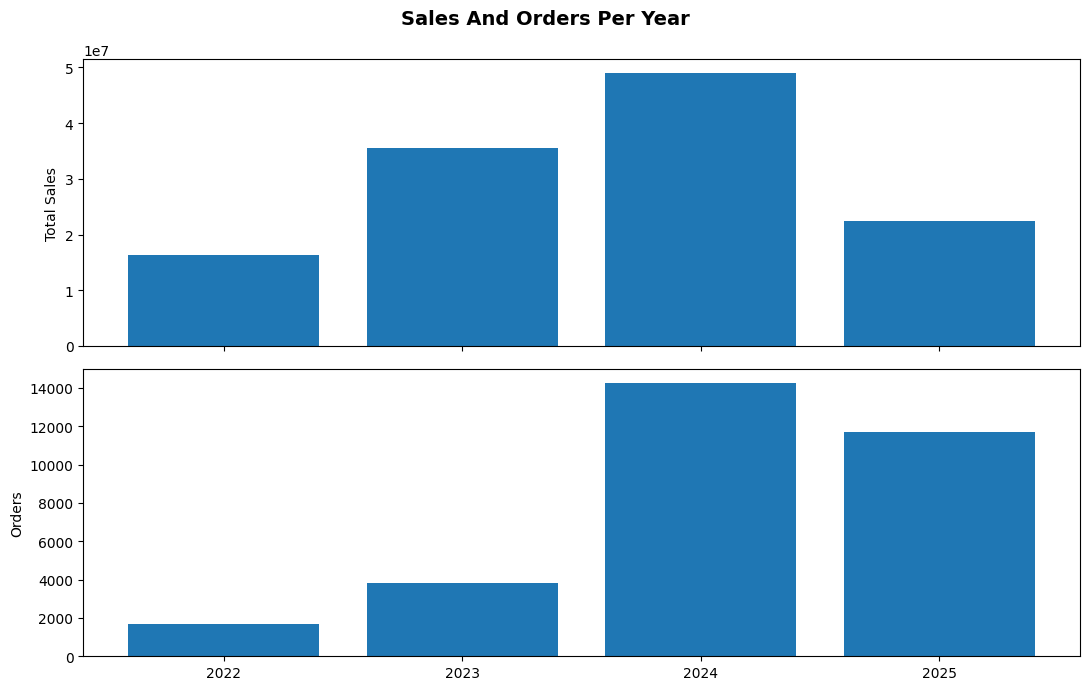

Highest Sales: 2024 (49020486.512)
Lowest Sales: 2022 (16316694.169)
Highest Orders: 2024 (14244)
Lowest Orders: 2022 (1692)


In [6]:
query_vis_4 = """
SELECT
    YEAR(OrderDate) AS [Year],
    SUM(TotalDue) AS TotalSales,
    COUNT(*) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY [Year]
"""

df_vis_4 = query_df(query_vis_4)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11,7), sharex=True)
fig.suptitle("Sales And Orders Per Year", fontsize=14, fontweight='bold')
ax1.bar(df_vis_4["Year"], df_vis_4["TotalSales"])
ax1.set_ylabel("Total Sales")

ax2.bar(df_vis_4["Year"], df_vis_4["OrderCount"])
ax2.set_ylabel("Orders")
ax2.set_xticks(df_vis_4["Year"])
ax2.set_xticklabels(df_vis_4["Year"])
plt.tight_layout()
plt.show()

max_sales = df_vis_4.loc[df_vis_4['TotalSales'].idxmax()]
min_sales = df_vis_4.loc[df_vis_4["TotalSales"].idxmin()]
max_orders = df_vis_4.loc[df_vis_4['OrderCount'].idxmax()]
min_orders = df_vis_4.loc[df_vis_4['OrderCount'].idxmin()]

print(f"Highest Sales: {int(max_sales['Year'])} ({max_sales['TotalSales']:})")
print(f"Lowest Sales: {int(min_sales['Year'])} ({min_sales['TotalSales']:})")
print(f"Highest Orders: {int(max_orders['Year'])} ({int(max_orders['OrderCount'])})")
print(f"Lowest Orders: {int(min_orders['Year'])} ({int(min_orders['OrderCount'])})")

### Insights – Sales And Orders Per Year
* Highest Yearly Sales: 2024 (49020486.512)
* Lowest Yearly Sales: 2022 (16316694.169)
* Highest Yearly Orders: 2024 (14244)
* Lowest Yearly Orders: 2022 (1692)

Both total sales and number of orders increase over time, indicating growing trend.
This suggests a healthy expansion in customer activity over the observed years.

If total sales increase faster than order volume, this suggests increasing average order value.
If both increase similar, growth is likely driven by higher customer activity.

## Visualization 5: Top 10 Products
What Top 10 products generates most sales?

Tables used:
* Production.Product
* Sales.SalesOrderDetail

Execution:
* Join products with sales order details
* Aggregate total sales per product
* Select top 10 products by total sales
* Create horizontal bar chart
* Analyze top-performing products

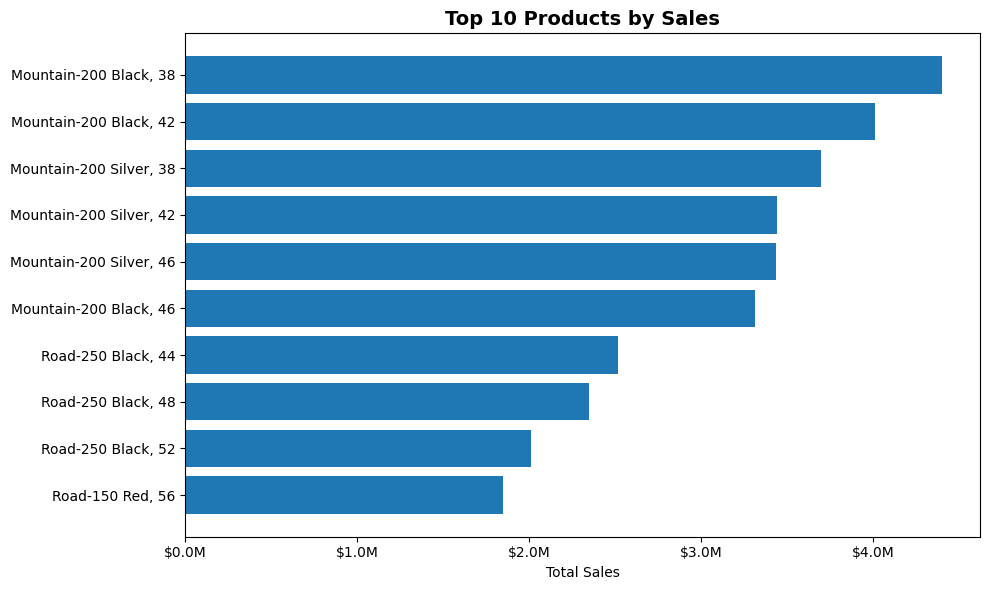

#1 Product: Mountain-200 Black, 38 (4400592.80)
Dominant category in Top 10: Bikes (10 of 10 products)


In [7]:
query_vis_5 = """
SELECT TOP 10
    p.Name AS ProductName,
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail AS sod
JOIN Production.Product AS p ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory AS psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory AS pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.Name, pc.Name
ORDER BY TotalSales DESC
"""

df_vis_5 = query_df(query_vis_5)

plt.figure(figsize=(10, 6))
plt.barh(df_vis_5["ProductName"], df_vis_5["TotalSales"])
plt.title("Top 10 Products by Sales", fontsize=14, fontweight='bold')
plt.xlabel("Total Sales")
plt.gca().invert_yaxis()  # Highest at the top

ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'${x/1_000_000:.1f}M'))

plt.tight_layout()
plt.show()

top_product = df_vis_5.iloc[0]
category_counts = df_vis_5["CategoryName"].value_counts()
dominant_category = category_counts.idxmax()
dominant_count = category_counts.max()

print(f"#1 Product: {top_product['ProductName']} " f"({top_product['TotalSales']:.2f})")
print(f"Dominant category in Top 10: {dominant_category} " f"({dominant_count} of 10 products)")


### Insights – Top 10 Products
* The number 1 selling product is Mountain-200 Black, 38 (4400592.80).
* The most dominant category is Bikes (10/10)

This suggests that a relatively small subset of products drives a large share of total revenue.

## Visualization 6: Sales And Number Of Customers Per Region
Diffrences in Sales per Region. And how many unique customers per region?

Tables used:
* Sales.SalesTerritory
* Sales.SalesOrderHeader
* Sales.Customer

Execution:
* Aggregate total sales per region
* Count unique customers per region
* Sort regions by total sales
* Create grouped bar visualization
* Analyze result

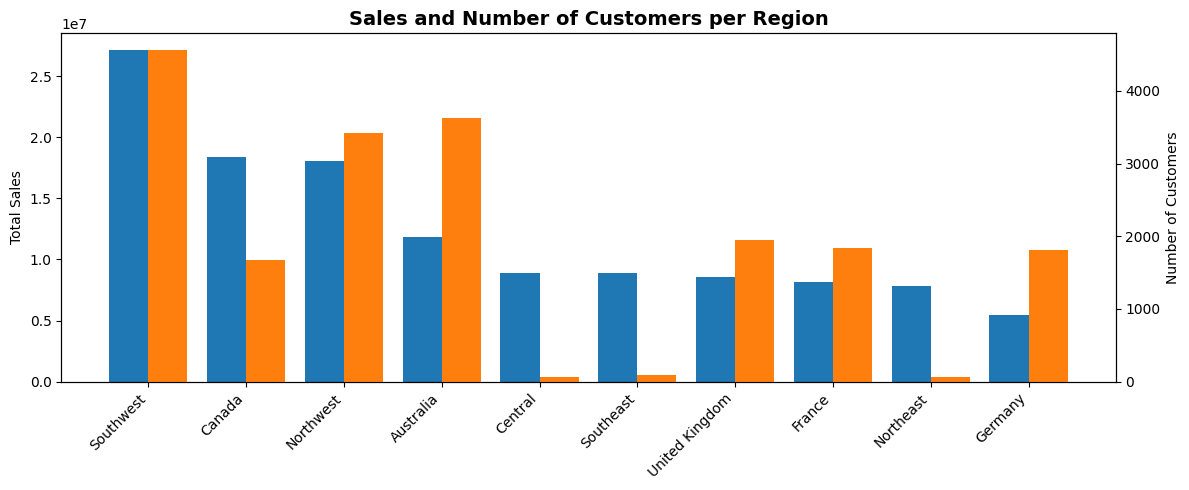

Strongest region: Southwest (27,150,594.5893)
Weakest region: Germany (5,479,819.5755)
Southwest sales/customer: 5,947.556317
Most customers: Southwest (4565)
Strongest region also highest customer count?: Yes


In [8]:
query_vis_6 = """
SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS CustomerCount
FROM Sales.SalesOrderHeader AS soh
JOIN Sales.SalesTerritory AS st ON soh.TerritoryID = st.TerritoryID
JOIN Sales.Customer AS c ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""

df_vis_6 = query_df(query_vis_6)

regions = df_vis_6["Region"].values
sales = df_vis_6["TotalSales"].values
customers = df_vis_6["CustomerCount"].values

x = np.arange(len(regions))
width = 0.4

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.bar(x - width/2, sales, width=width, color="tab:blue", label="Total Sales")
ax1.set_ylabel("Total Sales")
ax1.set_xticks(x)
ax1.set_xticklabels(regions, rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.bar(x + width/2, customers, width=width, color="tab:orange", label="Number of Customers")
ax2.set_ylabel("Number of Customers")

plt.title("Sales and Number of Customers per Region", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


best = df_vis_6.loc[df_vis_6["TotalSales"].idxmax()]
worst = df_vis_6.loc[df_vis_6["TotalSales"].idxmin()]

most_customers = df_vis_6.loc[df_vis_6["CustomerCount"].idxmax()]
best_sales_per_customer = best["TotalSales"] / best["CustomerCount"]
mostcust_sales_per_customer = most_customers["TotalSales"] / most_customers["CustomerCount"]

print(f"Strongest region: {best['Region']} ({best['TotalSales']:,.4f})")
print(f"Weakest region: {worst['Region']} ({worst['TotalSales']:,.4f})")
print(f"{best['Region']} sales/customer: {best_sales_per_customer:,.6f}")

print(f"Most customers: {most_customers['Region']} ({int(most_customers['CustomerCount'])})")
print(f"Strongest region also highest customer count?: {'Yes' if best['Region'] == most_customers['Region'] else 'No'}")

### Insights – Sales And Number Of Customers Per Region
* Strongest region: Southwest (27,150,594.5893)
* Weakest region: Germany (5,479,819.5755)
* Southwest sales/customer: 5,947.556317
* Most customers: Southwest (4565)
* Strongest region also highest customer count?: Yes

The leading region has high sales relative to its customer base, suggesting higher average order values.
Sales per customer varies between regions, suggesting different customer behavior, purchasing power, or products.

## Visualization 7: Average Order Value Per Region And Customer Type
Which regions has the highest/lowest average order value and diffrences between individual customers and business clients?

Tables used:
* Sales.SalesTerritory
* Sales.SalesOrderHeader
* Sales.Customer
* Sales.Store

Execution:
* Join sales orders with territories and customers
* Classify customer type (Store vs Individual)
* Calculate average order value per region and customer type
* Sort regions by overall average order value
* Create grouped bar chart

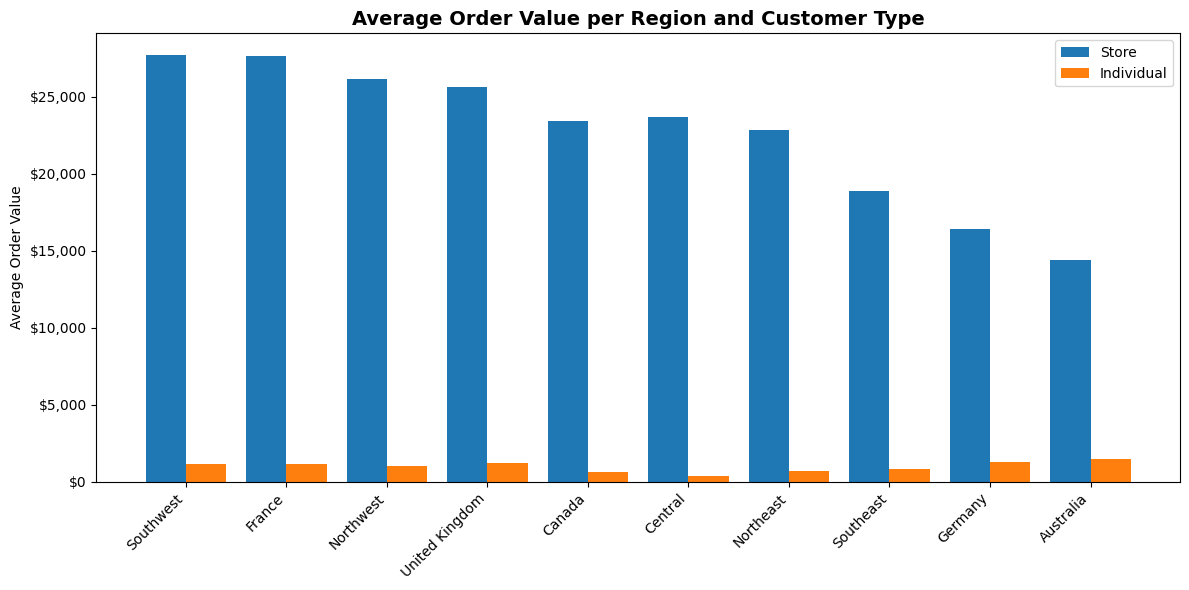

Highest AOV: Southwest – Store (27,739.06)
Average Store AOV: 22,694.81
Average Individual AOV: 987.23


In [9]:
query_vis_7 = """
SELECT
    st.Name AS Region,
    CASE
        WHEN s.BusinessEntityID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS CustomerType,
    SUM(soh.TotalDue) / COUNT(soh.SalesOrderID) AS AvgOrderValue
FROM Sales.SalesOrderHeader AS soh
JOIN Sales.SalesTerritory AS st ON soh.TerritoryID = st.TerritoryID
JOIN Sales.Customer AS c ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store AS s ON c.StoreID = s.BusinessEntityID
GROUP BY st.Name,
    CASE
        WHEN s.BusinessEntityID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END;
"""

df_vis_7 = query_df(query_vis_7)

df_pivot = (df_vis_7.pivot(index="Region", columns="CustomerType", values="AvgOrderValue").reset_index())
df_pivot["OverallAvg"] = df_pivot[["Store", "Individual"]].mean(axis=1)
df_pivot = df_pivot.sort_values("OverallAvg", ascending=False)
regions = df_pivot["Region"].values
store_aov = df_pivot["Store"].values
individual_aov = df_pivot["Individual"].values

x = np.arange(len(regions))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, store_aov, width=width, color="tab:blue", label="Store")
plt.bar(x + width/2, individual_aov, width=width, color="tab:orange", label="Individual")

plt.xticks(x, regions, rotation=45, ha="right")
plt.ylabel("Average Order Value")
plt.title("Average Order Value per Region and Customer Type", fontsize=14, fontweight="bold")
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

max_row = df_vis_7.loc[df_vis_7["AvgOrderValue"].idxmax()]
store_avg = df_vis_7[df_vis_7["CustomerType"] == "Store"]["AvgOrderValue"].mean()
ind_avg = df_vis_7[df_vis_7["CustomerType"] == "Individual"]["AvgOrderValue"].mean()

print(f"Highest AOV: {max_row['Region']} – {max_row['CustomerType']} "f"({max_row['AvgOrderValue']:,.2f})")
print(f"Average Store AOV: {store_avg:,.2f}")
print(f"Average Individual AOV: {ind_avg:,.2f}")

### Insights – Average Order Value Per Region And Customer Type
* Highest AOV: Southwest – Store (27,739.06)
* Average Store AOV: 22,694.81
* Average Individual AOV: 987.23

Across most regions, Store customers show higher average order values than Individual customers, suggesting that corporate clients tend to place larger or higher-value orders.

However, the magnitude of this difference varies by region, indicating differences in purchasing behavior, market maturity, or customer composition.